# 04 Graph Models
### Goal: build LCC, generate Node2Vec embeddings, visualize with t-SNE/UMAP, save artifacts.


Embeddings shape: (7880, 131)
Embedding cols: 128
NaNs in embedding: 0
Var (first 5 dims): {'e0': 0.012804, 'e1': 0.007956, 'e2': 0.005335, 'e3': 0.00464, 'e4': 0.004015}


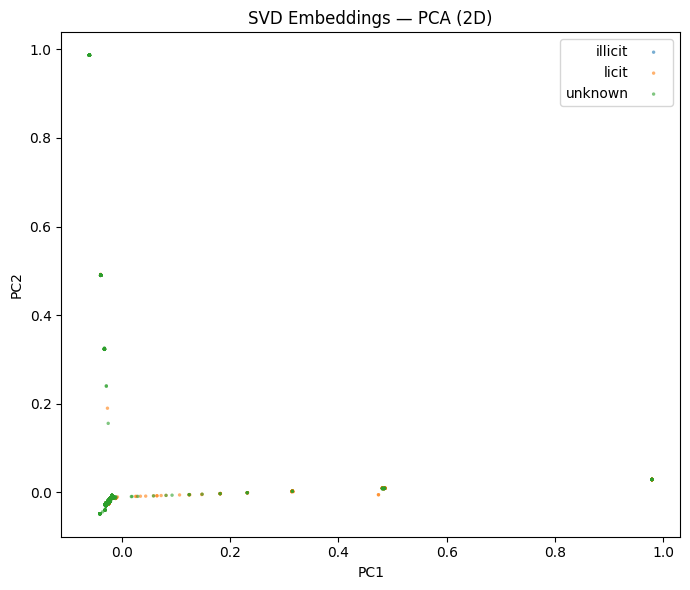

Saved PCA figure -> ../reports/figures/04_emb_pca_2d.png


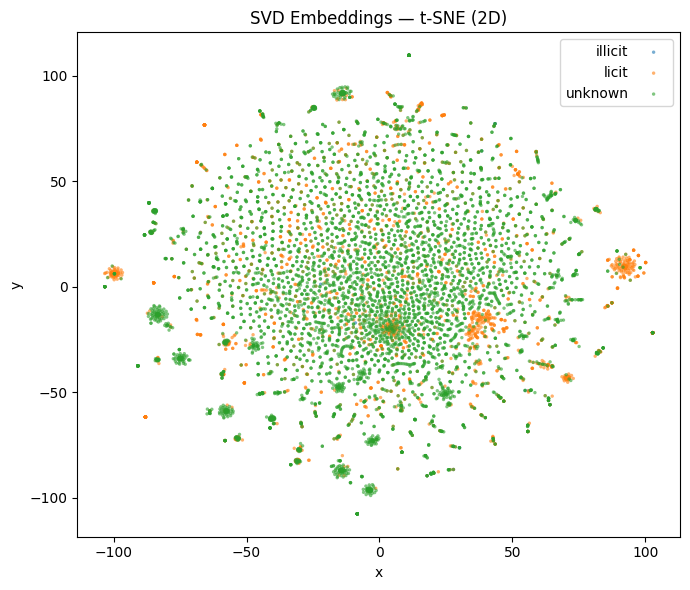

Saved t-SNE figure -> ../reports/figures/04_emb_tsne_2d.png


In [12]:
# === Embedding sanity check + 2D visualization ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

DATA_PROCESSED = Path("../data/processed")
REPORT_FIG = Path("../reports/figures")
REPORT_FIG.mkdir(parents=True, exist_ok=True)

# 1) Load embeddings
emb_path = DATA_PROCESSED / "embeddings_node2vec.parquet"
emb_df = pd.read_parquet(emb_path)
emb_cols = [c for c in emb_df.columns if c.startswith("e")]
print("Embeddings shape:", emb_df.shape)
print("Embedding cols:", len(emb_cols))

# 2) Quick stats
print("NaNs in embedding:", int(np.isnan(emb_df[emb_cols].values).sum()))
print("Var (first 5 dims):", emb_df[emb_cols].var().head().round(6).to_dict())

# 3) PCA -> 2D
pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(emb_df[emb_cols].values)
pca_df = pd.DataFrame(xy, columns=["pc1","pc2"])
pca_df["label"] = emb_df["label"].astype(str)

# Focus on labeled points for coloring; unknown = light gray
label_map = {"1": "illicit", "2": "licit", "unknown": "unknown"}
pca_df["label_clean"] = pca_df["label"].map(label_map).fillna(pca_df["label"])

# Subsample for plotting speed
max_pts = 10000
plot_df = pca_df.sample(n=min(max_pts, len(pca_df)), random_state=42)

plt.figure(figsize=(7,6))
for name, color in [("illicit","#d62728"), ("licit","#2ca02c"), ("unknown","#cccccc")]:
    sub = plot_df[plot_df["label_clean"]==name]
    plt.scatter(sub["pc1"], sub["pc2"], s=6, alpha=0.6, label=name, edgecolors="none")
plt.title("SVD Embeddings — PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(markerfirst=False)
plt.tight_layout()
out_pca = REPORT_FIG / "04_emb_pca_2d.png"
plt.savefig(out_pca, dpi=150)
plt.show()
print("Saved PCA figure ->", out_pca)

# 4) (Optional) t-SNE if available
try:
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=30, random_state=42)
    xy_tsne = tsne.fit_transform(emb_df[emb_cols].values[:max_pts])
    tsne_df = pd.DataFrame(xy_tsne, columns=["x","y"])
    tsne_df["label"] = emb_df["label"].astype(str).iloc[:len(tsne_df)]
    tsne_df["label_clean"] = tsne_df["label"].map(label_map).fillna(tsne_df["label"])
    
    plt.figure(figsize=(7,6))
    for name, color in [("illicit","#d62728"), ("licit","#2ca02c"), ("unknown","#cccccc")]:
        sub = tsne_df[tsne_df["label_clean"]==name]
        plt.scatter(sub["x"], sub["y"], s=6, alpha=0.6, label=name, edgecolors="none")
    plt.title("SVD Embeddings — t-SNE (2D)")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend(markerfirst=False)
    plt.tight_layout()
    out_tsne = REPORT_FIG / "04_emb_tsne_2d.png"
    plt.savefig(out_tsne, dpi=150)
    plt.show()
    print("Saved t-SNE figure ->", out_tsne)
except Exception as e:
    print("t-SNE not available or failed; skipped.", repr(e))


#### 1) SVD Embeddings — PCA (2D)

A sanity check plot.
We project the (sparse) adjacency-based SVD embeddings to 2D with PCA. The shape looks highly compressed because SVD is a linear method applied to a very sparse graph matrix; most variance sits on a few axes, so points collapse near the axes. This is expected and mainly serves to confirm the embedding file is valid and numeric (no NaNs/inf).

Takeaway: visual separation is limited with PCA here; use a non-linear view (t-SNE/UMAP) to inspect local structure.

#### 2) SVD Embeddings — t-SNE (2D)

A more informative, non-linear view.
t-SNE preserves local neighborhoods, so clusters of nodes that co-occur in the graph tend to appear together. You’ll often see small islands and dense blobs—these may correspond to tightly interacting transaction groups. Colors (illicit/lict/unknown) show partial alignment: unknown nodes intermix with licit clusters (expected), while some compact blobs contain more licit nodes.

Takeaway: even this lightweight SVD baseline captures useful local structure; it motivates trying true Node2Vec (or DeepWalk) when installation allows.

In [15]:
# === Quick modeling with embeddings (time-split aligned, robust IO) ===
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_PROCESSED = Path("../data/processed")
DATA_INTERIM = Path("../data/interim")

def load_df_any(name: str) -> pd.DataFrame:
    """Load a DataFrame from processed/ by trying parquet first then csv."""
    p_parquet = DATA_PROCESSED / f"{name}.parquet"
    p_csv     = DATA_PROCESSED / f"{name}.csv"
    if p_parquet.exists():
        return pd.read_parquet(p_parquet)
    if p_csv.exists():
        return pd.read_csv(p_csv)
    raise FileNotFoundError(f"Neither parquet nor csv found for {name} in {DATA_PROCESSED}")

# 1) Load tabular splits and labels (from Notebook 2 outputs)
X_train = load_df_any("X_train")
X_valid = load_df_any("X_valid")
X_test  = load_df_any("X_test")

y_train = load_df_any("y_train")["label"].values
y_valid = load_df_any("y_valid")["label"].values
y_test  = load_df_any("y_test")["label"].values

# txId order as saved in 02 (align embeddings row-by-row)
train_ids = pd.read_parquet(DATA_INTERIM / "train_ids.parquet")["txId"].values
valid_ids = pd.read_parquet(DATA_INTERIM / "valid_ids.parquet")["txId"].values
test_ids  = pd.read_parquet(DATA_INTERIM / "test_ids.parquet")["txId"].values

# 2) Load embeddings produced in Cell 1 (Node2Vec or SVD fallback share the same filename)
emb_path_parquet = DATA_PROCESSED / "embeddings_node2vec.parquet"
emb_path_csv     = DATA_PROCESSED / "embeddings_node2vec.csv"
if emb_path_parquet.exists():
    emb_df = pd.read_parquet(emb_path_parquet)
elif emb_path_csv.exists():
    emb_df = pd.read_csv(emb_path_csv)
else:
    raise FileNotFoundError("Embeddings not found. Run Cell 1 to create 'embeddings_node2vec.parquet'.")

# Build a fast lookup: index by txId, keep only embedding columns e*
emb_cols = [c for c in emb_df.columns if c.startswith("e")]
emb_map = emb_df.set_index("txId")[emb_cols]

def rows_by_ids(emb_lut: pd.DataFrame, ids: np.ndarray) -> np.ndarray:
    """Return embedding rows aligned to ids; fill zeros for ids without embeddings (non-LCC nodes)."""
    if len(emb_lut) == 0:
        raise ValueError("Empty embeddings table.")
    dim = emb_lut.shape[1]
    # Faster than Python loop: build DataFrame and reindex
    tmp = pd.DataFrame(index=ids)
    out = emb_lut.reindex(tmp.index).to_numpy()
    # Fill missing rows with zeros
    out = np.where(np.isnan(out), 0.0, out)
    return out.astype(np.float32, copy=False)

E_train = rows_by_ids(emb_map, train_ids)
E_valid = rows_by_ids(emb_map, valid_ids)
E_test  = rows_by_ids(emb_map, test_ids)

print("Shapes — tabular:", X_train.shape, X_valid.shape, X_test.shape)
print("Shapes — embed  :", E_train.shape, E_valid.shape, E_test.shape)

# 3) Simple logistic baselines on Valid & Test
def eval_lr(Xtr, ytr, Xva, yva, Xte, yte, tag: str):
    lr = LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_SEED, n_jobs=None)
    lr.fit(Xtr, ytr)
    proba_va = lr.predict_proba(Xva)[:, 1]
    proba_te = lr.predict_proba(Xte)[:, 1]
    res = {
        "tag": tag,
        "valid_pr_auc":  float(average_precision_score(yva, proba_va)),
        "valid_roc_auc": float(roc_auc_score(yva, proba_va)),
        "test_pr_auc":   float(average_precision_score(yte, proba_te)),
        "test_roc_auc":  float(roc_auc_score(yte, proba_te)),
    }
    print(f"{tag:>20} | Valid PR-AUC={res['valid_pr_auc']:.4f} ROC-AUC={res['valid_roc_auc']:.4f} "
          f"| Test PR-AUC={res['test_pr_auc']:.4f} ROC-AUC={res['test_roc_auc']:.4f}")
    return res

summary_rows = []
# A) Embeddings only
summary_rows.append(eval_lr(E_train, y_train, E_valid, y_valid, E_test, y_test, "Embeddings only"))
# B) Tabular only
summary_rows.append(eval_lr(X_train.values, y_train, X_valid.values, y_valid, X_test.values, y_test, "Tabular only"))
# C) Concatenation
Xtr_cat = np.hstack([X_train.values, E_train])
Xva_cat = np.hstack([X_valid.values, E_valid])
Xte_cat = np.hstack([X_test.values,  E_test])
summary_rows.append(eval_lr(Xtr_cat, y_train, Xva_cat, y_valid, Xte_cat, y_test, "Tabular + Embeddings"))

summary_df = pd.DataFrame(summary_rows).sort_values(by=["test_pr_auc","valid_pr_auc"], ascending=False)
display(summary_df)

# Save a small report
out_csv = DATA_PROCESSED / "04_emb_baselines_summary.csv"
summary_df.to_csv(out_csv, index=False)
print("Saved summary ->", out_csv)


Shapes — tabular: (32595, 121) (4656, 121) (9313, 121)
Shapes — embed  : (32595, 128) (4656, 128) (9313, 128)
     Embeddings only | Valid PR-AUC=0.1213 ROC-AUC=0.5035 | Test PR-AUC=0.1424 ROC-AUC=0.5000
        Tabular only | Valid PR-AUC=0.7098 ROC-AUC=0.9609 | Test PR-AUC=0.7609 ROC-AUC=0.9660
Tabular + Embeddings | Valid PR-AUC=0.7090 ROC-AUC=0.9608 | Test PR-AUC=0.7604 ROC-AUC=0.9659


,tag,valid_pr_auc,valid_roc_auc,test_pr_auc,test_roc_auc
1,Tabular only,0.709840,0.960940,0.760933,0.965984
2,Tabular + Embeddings,0.708992,0.960812,0.760360,0.965908
0,Embeddings only,0.121284,0.503511,0.142382,0.500000


Saved summary -> ../data/processed/04_emb_baselines_summary.csv
